In [42]:
!pip install evaluate

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached datasets-3.3.2-py3-none-any.whl.metadata (19 kB)
  Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached pyarrow-19.0.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
Using cached datasets-3.3.2-py3-none-any.whl (485 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached multiprocess-0.70.16-py312-none-any.whl (146 kB)
Using cached xxhash-3.5.0-cp312-cp312-macosx_11_0_arm64.whl (30 kB)
Using cached pyarrow-19.0.1-cp312-cp312-macosx_12_0_arm64.whl (30.7 MB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [59]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display
from sklearn.metrics import accuracy_score, classification_report

In [60]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from tqdm import tqdm
from torchmetrics.classification import MultilabelAccuracy
from datasets import Dataset
import pickle
import random
import evaluate
from pythainlp.tokenize import word_tokenize


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
import wandb
wandb.login(key="32eb1af2ce5cbc376d70161f63865638e4e01bfd")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/idhibhatpankam/.netrc


True

In [48]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
# train_df = pd.read_csv('/kaggle/input/dataset/train.csv')
# test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
train_df.head()

,id,comment,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,0,0,0,0,0,0,0,0,0,0,0,0
1,1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,0,0,0,0,0,0,0,0,0,0,0,0
2,2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,0,0,0,0,0,0,0,0,0,0,0,0
3,3,ปัญหาน้ำท่วมในซอยสวนพลู 1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
train_df.describe()

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
count,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000,204622.000000
mean,102310.500000,0.209635,0.019969,0.000049,0.016034,0.000117,0.167944,0.034542,0.000406,0.024176,0.018478,0.000059,0.023839
std,59069.427728,0.407049,0.139892,0.006991,0.125608,0.010829,0.373817,0.182616,0.020136,0.153597,0.134672,0.007658,0.152548
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51155.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,102310.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,153465.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,204621.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
def drop_rows(df):
    # drop rows with missing values, duplicates
    print(f"Before dropna: {df.shape}")
    df.dropna(inplace=True)
    df.drop_duplicates("comment", keep="first", inplace=True)
    df = df.reset_index(drop=True)
    print(f"After dropna: {df.shape}")

drop_rows(train_df)
drop_rows(test_df)
print(train_df.shape, test_df.shape)

Before dropna: (204622, 14)
After dropna: (204622, 14)
Before dropna: (10810, 2)
After dropna: (10810, 2)
(204622, 14) (10810, 2)


In [51]:
contacts = train_df.columns[2:]

train_df['label'] = train_df[contacts].apply(lambda x: list(x), axis=1)
train_df.drop(contacts, axis=1, inplace=True)
train_df.drop("id", axis=1, inplace=True)

test_df.drop("id", axis=1, inplace=True)
train_df.head()

,comment,label
0,บริเวณนราธิวาส แยกถนนจันทน์ ใกล้สวนสาธารณะช่อ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซน...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,ปัญหาน้ำท่วมในซอยสวนพลู 1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1. ซ่อมสายไฟ กรีดขวางทางเท้า,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [52]:
train_df['label'].value_counts()

label
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    102333
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     42212
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]     32543
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]      5803
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]      4598
                                         ...  
[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]         1
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]         1
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]         1
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]         1
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]         1
Name: count, Length: 73, dtype: int64

In [53]:
contacts

Index(['สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
       'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต',
       'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ',
       'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ',
       'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'],
      dtype='object')

In [85]:
def plot_sample_length(lengths: list[int], title: str):
    print(f"Min length: {min(lengths)}")
    print(f"Max length: {max(lengths)}")
    print(f"Mean length: {np.mean(lengths):.2f}")
    print(f"Median length: {np.median(lengths)}")

    plt.hist(lengths, bins=20, edgecolor='black')
    plt.xlabel('Number of tokens')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

In [82]:
train_lengths = [len(word_tokenize(d)) for d in tqdm(train_df['comment'])]
test_lengths = [len(word_tokenize(d)) for d in tqdm(test_df['comment'])]

100%|██████████| 10810/10810 [00:03<00:00, 3228.87it/s]


Min length: 1
Max length: 1769
Mean length: 50.96
Median length: 33.0


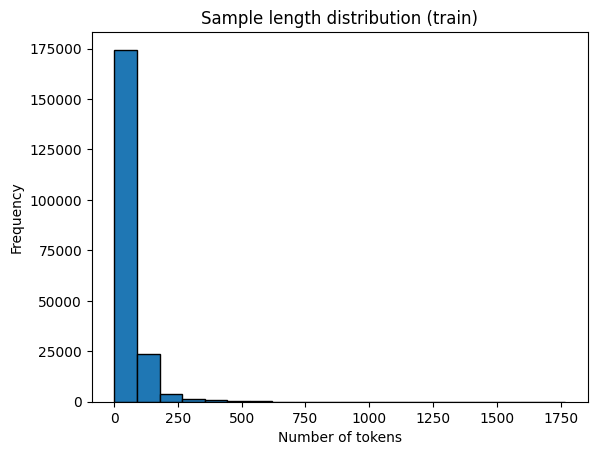

In [86]:
plot_sample_length(train_lengths, 'Sample length distribution (train)')

Min length: 1
Max length: 1446
Mean length: 50.70
Median length: 32.0


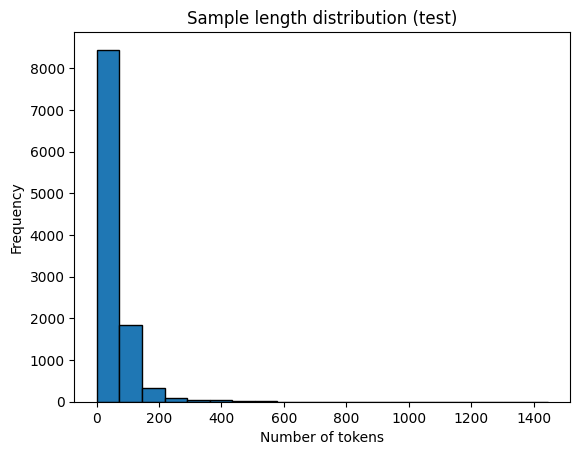

In [87]:
plot_sample_length(test_lengths, 'Sample length distribution (test)')

In [89]:
def count_exceeded_length(lengths: list[int], max_length: int):
    exceed = len([l for l in lengths if l > max_length])
    print(f"Number of samples exceeding {max_length} tokens: {exceed}")
    print(f"Percentage of samples exceeding {max_length} tokens: {exceed / len(lengths) * 100:.2f}%")

max_length = 128
print("TRAIN")
count_exceeded_length(train_lengths, max_length)
print("\nTEST")
count_exceeded_length(test_lengths, max_length)

TRAIN
Number of samples exceeding 128 tokens: 12866
Percentage of samples exceeding 128 tokens: 6.29%

TEST
Number of samples exceeding 128 tokens: 695
Percentage of samples exceeding 128 tokens: 6.43%


In [54]:
train_data = train_df.copy().to_numpy()
test_data = test_df.copy().to_numpy()

label_2_idx = dict(zip(contacts, range(len(contacts))))
idx_2_label = dict(zip(range(len(contacts)), contacts))

print("Create Mappings")
display(idx_2_label)
display(label_2_idx)

# print("Before Mappings")
# display(data[:, 1])
# data[:,1] = np.vectorize(label_2_num_map.get)(data[:,1])
# print("After Mappings")
# display(data[:, 1])

Create Mappings


{0: 'สำนักงานตำรวจแห่งชาติ',
 1: 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
 2: 'สภาเด็กและเยาวชนกรุงเทพมหานคร',
 3: 'กรมควบคุมมลพิษ',
 4: 'กรมสรรพสามิต',
 5: 'การไฟฟ้านครหลวง',
 6: 'กรมทางหลวง',
 7: 'สำนักงานประกันสุขภาพแห่งชาติ',
 8: 'การประปานครหลวง',
 9: 'คณะกรรมการการพัฒนาเศรษฐกิจ',
 10: 'กระทรวงการท่องเที่ยวและกีฬา',
 11: 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'}

{'สำนักงานตำรวจแห่งชาติ': 0,
 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย': 1,
 'สภาเด็กและเยาวชนกรุงเทพมหานคร': 2,
 'กรมควบคุมมลพิษ': 3,
 'กรมสรรพสามิต': 4,
 'การไฟฟ้านครหลวง': 5,
 'กรมทางหลวง': 6,
 'สำนักงานประกันสุขภาพแห่งชาติ': 7,
 'การประปานครหลวง': 8,
 'คณะกรรมการการพัฒนาเศรษฐกิจ': 9,
 'กระทรวงการท่องเที่ยวและกีฬา': 10,
 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200': 11}

In [55]:
def set_random_seed(seed: int):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed(42)

In [58]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, revision='main', model_max_length=128)

ValueError: Converting from Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast convertors: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']

In [ ]:
X_train_tokens = tokenizer(train_data[:,0].tolist(), truncation=True, padding=True)
X_test_tokens = tokenizer(test_data[:,0].tolist(), truncation=True, padding=True)
num_labels = len(label_2_idx)

In [72]:
y_train = np.array(train_data[:,1].tolist(), dtype=np.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

y_train_np = y_train.numpy()
# new column: 1 if the row is all zeros, else 0
new_column = np.where(np.all(y_train_np == 0, axis=1), 1, 0).reshape(-1, 1)
y_train_np = np.hstack([y_train_np, new_column])

y_train = torch.tensor(y_train_np, dtype=torch.float32)


y_test = np.array([[0] * 13 for _ in range(test_data.shape[0])], dtype=np.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

y_train.shape, y_test.shape

(torch.Size([204622, 13]), torch.Size([10810, 13]))

In [73]:
train_dataset = Dataset.from_dict({
    "input_ids": X_train_tokens["input_ids"],
    "attention_mask": X_train_tokens["attention_mask"],
    "labels": y_train
})

test_dataset = Dataset.from_dict({
    "input_ids": X_test_tokens["input_ids"],
    "attention_mask": X_test_tokens["attention_mask"],
    "labels": y_test
})

In [74]:
num_labels = 13
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="multi_label_text_classification_wangchanberta_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

In [ ]:
classifier_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):
   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return classifier_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))

In [77]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-77-217194651456>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [78]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.080300,0.185344,0.927389,0.000000,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


KeyboardInterrupt: 

In [79]:
import shutil

shutil.make_archive("/kaggle/working/checkpoint-6395", "zip", "/kaggle/working/multi_label_text_classification_wangchanberta_model/checkpoint-6395")


'/kaggle/working/checkpoint-6395.zip'

In [80]:
predictions = trainer.predict(test_dataset)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
logits = torch.tensor(predictions.predictions)
probs = torch.sigmoid(logits)
pred_labels = (probs > 0.5).int().tolist()
processed_pred_labels = []
for pl in pred_labels:
    if pl == [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]:
        processed_pred_labels.append(pl[:-1])
    else:
        processed_pred_labels.append(pl[:-1])
pred_df = pd.DataFrame(processed_pred_labels, columns=contacts)

test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
output_df = pd.concat([test_df["id"], pred_df], axis=1)

In [81]:
logits = torch.tensor(predictions.predictions)
probs = torch.sigmoid(logits)
pred_labels = (probs > 0.5).int().tolist()
pred_df = pd.DataFrame(pred_labels, columns=contacts)

test_df = pd.read_csv('/kaggle/input/dataset/test.csv')
output_df = pd.concat([test_df["id"], pred_df], axis=1)

ValueError: 12 columns passed, passed data had 13 columns

In [87]:
output_df.to_csv('submission.csv', index=False)

In [88]:
output_df

,id,สำนักงานตำรวจแห่งชาติ,การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย,สภาเด็กและเยาวชนกรุงเทพมหานคร,กรมควบคุมมลพิษ,กรมสรรพสามิต,การไฟฟ้านครหลวง,กรมทางหลวง,สำนักงานประกันสุขภาพแห่งชาติ,การประปานครหลวง,คณะกรรมการการพัฒนาเศรษฐกิจ,กระทรวงการท่องเที่ยวและกีฬา,สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,1,0,0,0,0,0
4,4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10805,10805,0,0,0,0,0,0,0,0,0,0,0,0
10806,10806,0,0,0,0,0,0,0,0,0,0,0,0
10807,10807,0,0,0,0,0,0,0,0,0,0,0,0
10808,10808,0,0,0,0,0,0,0,0,0,0,0,0
